In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

In [31]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data-cifar10', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data-cifar10', train=False, download=True, transform=transform)

# Split train dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [33]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, criterion, optimizer, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        train_losses.append(running_loss / len(trainloader))
        val_losses.append(val_loss / len(valloader))
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {100 * correct / total:.2f}%")
    
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train vs Validation Loss')
    plt.show()

In [34]:
# Initialize model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

Epoch 1/10, Train Loss: 1.3961, Val Loss: 1.1674, Val Acc: 58.65%
Epoch 2/10, Train Loss: 1.0068, Val Loss: 0.9498, Val Acc: 66.88%
Epoch 3/10, Train Loss: 0.8260, Val Loss: 0.8865, Val Acc: 69.72%
Epoch 4/10, Train Loss: 0.6929, Val Loss: 0.8854, Val Acc: 69.43%
Epoch 5/10, Train Loss: 0.5707, Val Loss: 0.8636, Val Acc: 71.12%
Epoch 6/10, Train Loss: 0.4488, Val Loss: 0.9340, Val Acc: 70.90%
Epoch 7/10, Train Loss: 0.3391, Val Loss: 1.0328, Val Acc: 69.88%
Epoch 8/10, Train Loss: 0.2429, Val Loss: 1.0893, Val Acc: 71.05%
Epoch 9/10, Train Loss: 0.1589, Val Loss: 1.1964, Val Acc: 70.83%
Epoch 10/10, Train Loss: 0.1167, Val Loss: 1.3782, Val Acc: 69.86%


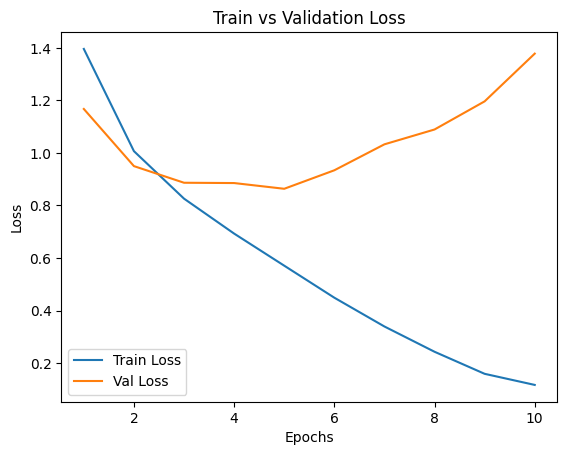

In [35]:
# Train the model
train_model(model, criterion, optimizer, epochs=10)

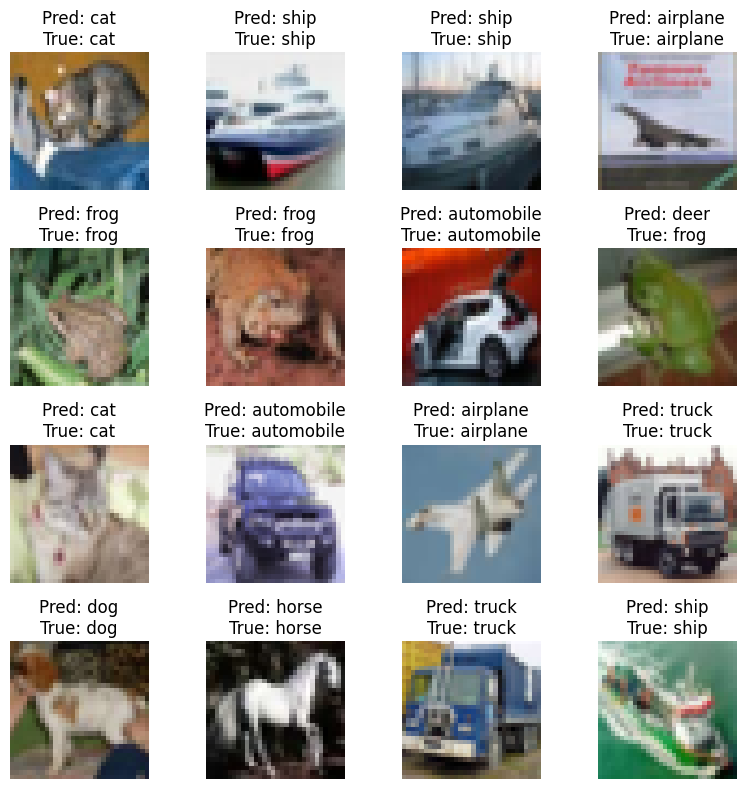

In [41]:
# Predict and visualize test images
def visualize_predictions():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    class_names = testset.classes
    images, labels = next(iter(testloader))
    images, labels = images[:16].to(device), labels[:16].to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = np.transpose(images[i], (1, 2, 0))
        img = img * 0.5 + 0.5  # Unnormalize
        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions()